In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()

# making sure plots & clusters are reproducible
np.random.seed(42)

Running Scanpy 1.8.2, on 2022-02-21 21:37.


In [2]:
# directory paths
master_table = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_invivo_exvivo_comparison/01_data/220212_MASTER_dge_correlation_table.csv'
data_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_invivo_exvivo_comparison/01_data/ASK_joint/GSEA/'
fig_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_invivo_exvivo_comparison/02_figures/ASK_joint/fibroblasts_treatment_effects/'

In [3]:
## plotting variables
sc.settings.figdir = fig_dir
sc.set_figure_params(vector_friendly = True)
plt.rcParams['figure.figsize'] = (8, 14)
plt.rcParams['pdf.fonttype'] = 42

In [4]:
## read master table
master = pd.read_csv(master_table, index_col=0)
master.head(5)

,Alveolar_Epithelium_invivo_log2FC,Alveolar_Epithelium_invivo_pval_adj,Alveolar_Epithelium_invivo_pct_healthy,Alveolar_Epithelium_invivo_pct_ILD,Alveolar_Epithelium_exvivo_log2FC,Alveolar_Epithelium_exvivo_pval_adj,Alveolar_Epithelium_exvivo_pct_CC,Alveolar_Epithelium_exvivo_pct_FC,Alveolar_Epithelium_CMP4_log2FC,Alveolar_Epithelium_CMP4_pval_adj,...,NK_cells_exvivo_pct_CC,NK_cells_exvivo_pct_FC,NK_cells_CMP4_log2FC,NK_cells_CMP4_pval_adj,NK_cells_CMP4_pct_CC,NK_cells_CMP4_pct_FC_CMP4,NK_cells_Nintedanib_log2FC,NK_cells_Nintedanib_pval_adj,NK_cells_Nintedanib_pct_CC,NK_cells_Nintedanib_pct_FC_Nintedanib
gene,,,,,,,,,,,,,,,,,,,,,
GPX1,10.0,0.0,0.208328,0.233239,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NAPRT,10.0,0.0,0.056900,0.035651,-0.775898,0.000006,0.193662,0.151819,-1.067108,6.361869e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CRYBG3,10.0,0.0,0.045819,0.050550,-0.267367,0.066029,0.268486,0.260979,-0.275646,3.066237e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TIFA,10.0,0.0,0.166655,0.089571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LUC7L2,10.0,0.0,0.137390,0.115999,NaN,NaN,NaN,NaN,-0.645198,3.971449e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,1.510993,0.000156,0.016423,0.077441


### Create dictionary of Gene sets and genes contained therein

In [5]:
gs_dict1 = {
    ### Nintedanib UP ###
    'WP: IL-1 signaling pathway' : ['STAT6', 'IKBKB', 'RELA','EP300', 'GAB2', 'MAPK14'],
    'WP: MAPK Signaling Pathway' : ['IKBKB', 'RELA', 'TAOK2', 'ARAF', 'MAP2K7', 'NFATC3', 'MAP3K5', 'CRKL', 'RPS6KA3', 'MAPK14', 'HSPA2', 'MAPK1'],
    
    ### Nintedanib DOWN ###
    'REAC: Signaling by PDGF' : ['COL6A2', 'COL5A1', 'COL5A3', 'PDGFRB'],
    'WP: VEGFA-VEGFR2 Signaling Pathway' : ['PFN1', 'TMSB10', 'CAPZB', 'EGR1', 'PRDX6', 'SH3BGRL3', 'AP2S1', 'SHC1', 'IDH2', 'PLAU', 'PBK', 'HMGB1', 'EGR3'],
    'WP: Canonical  and Non-canonical Notch signaling' : ['RRAS', 'NOTCH3', 'MFAP2'],
    'WP: TGF-beta Signaling Pathway' : ['RBX1', 'TNC', 'SHC1', 'FN1', 'CDK1', 'COL1A2']    
}

In [6]:
gs_dict2 = {
    ### cmp4 UP ###
    'KEGG: HIF-1 signaling pathway' : ['PFKL', 'AKT1', 'STAT3', 'ENO2', 'PGK1', 'ALDOC', 'SLC2A1'],
    'GO:BP: response to type I interferon' : ['HLA-A', 'IFITM2', 'MAVS', 'TRIM56', 'SP100', 'GBP2', 'SHFL'],
    'GO:BP: granulocyte activation' : ['GPI', 'DDX3X', 'IGF2R', 'GNS', 'EEF2', 'TRAF3IP2', 'ALDOC', 'FTH1', 'JUP', 'TMEM63A', 'ELANE'],
    
    ### cmp4 DOWN ###
    'KEGG: Signaling by ROBO receptors' : ['RPS24', 'RBX1', 'RPS10', 'RPS26', 'RPS15A'],
    'REAC: Signaling by Rho GTPases' : ['ACTR2', 'YWHAZ', 'DYNLL1', 'ACTB', 'MAD2L1', 'ECT2']
}

### Create logFC for visualization

In [7]:
dge_table = master[['Fibroblasts_invivo_log2FC','Fibroblasts_exvivo_log2FC',
                      'Fibroblasts_CMP4_log2FC','Fibroblasts_Nintedanib_log2FC']]

In [8]:
dgetab = ad.AnnData(X = dge_table.transpose())

In [9]:
dgetab.var_names_make_unique()

In [10]:
dgetab.obs['treatment_effect'] = dgetab.obs_names
dgetab.obs['treatment_effect'] = dgetab.obs['treatment_effect'].astype('category')

In [11]:
dgetab.obs['treatment_effect'] = dgetab.obs['treatment_effect'].cat.reorder_categories(['Fibroblasts_Nintedanib_log2FC',
                                                                                        'Fibroblasts_CMP4_log2FC',
                                                                                        'Fibroblasts_exvivo_log2FC',
                                                                                        'Fibroblasts_invivo_log2FC'])

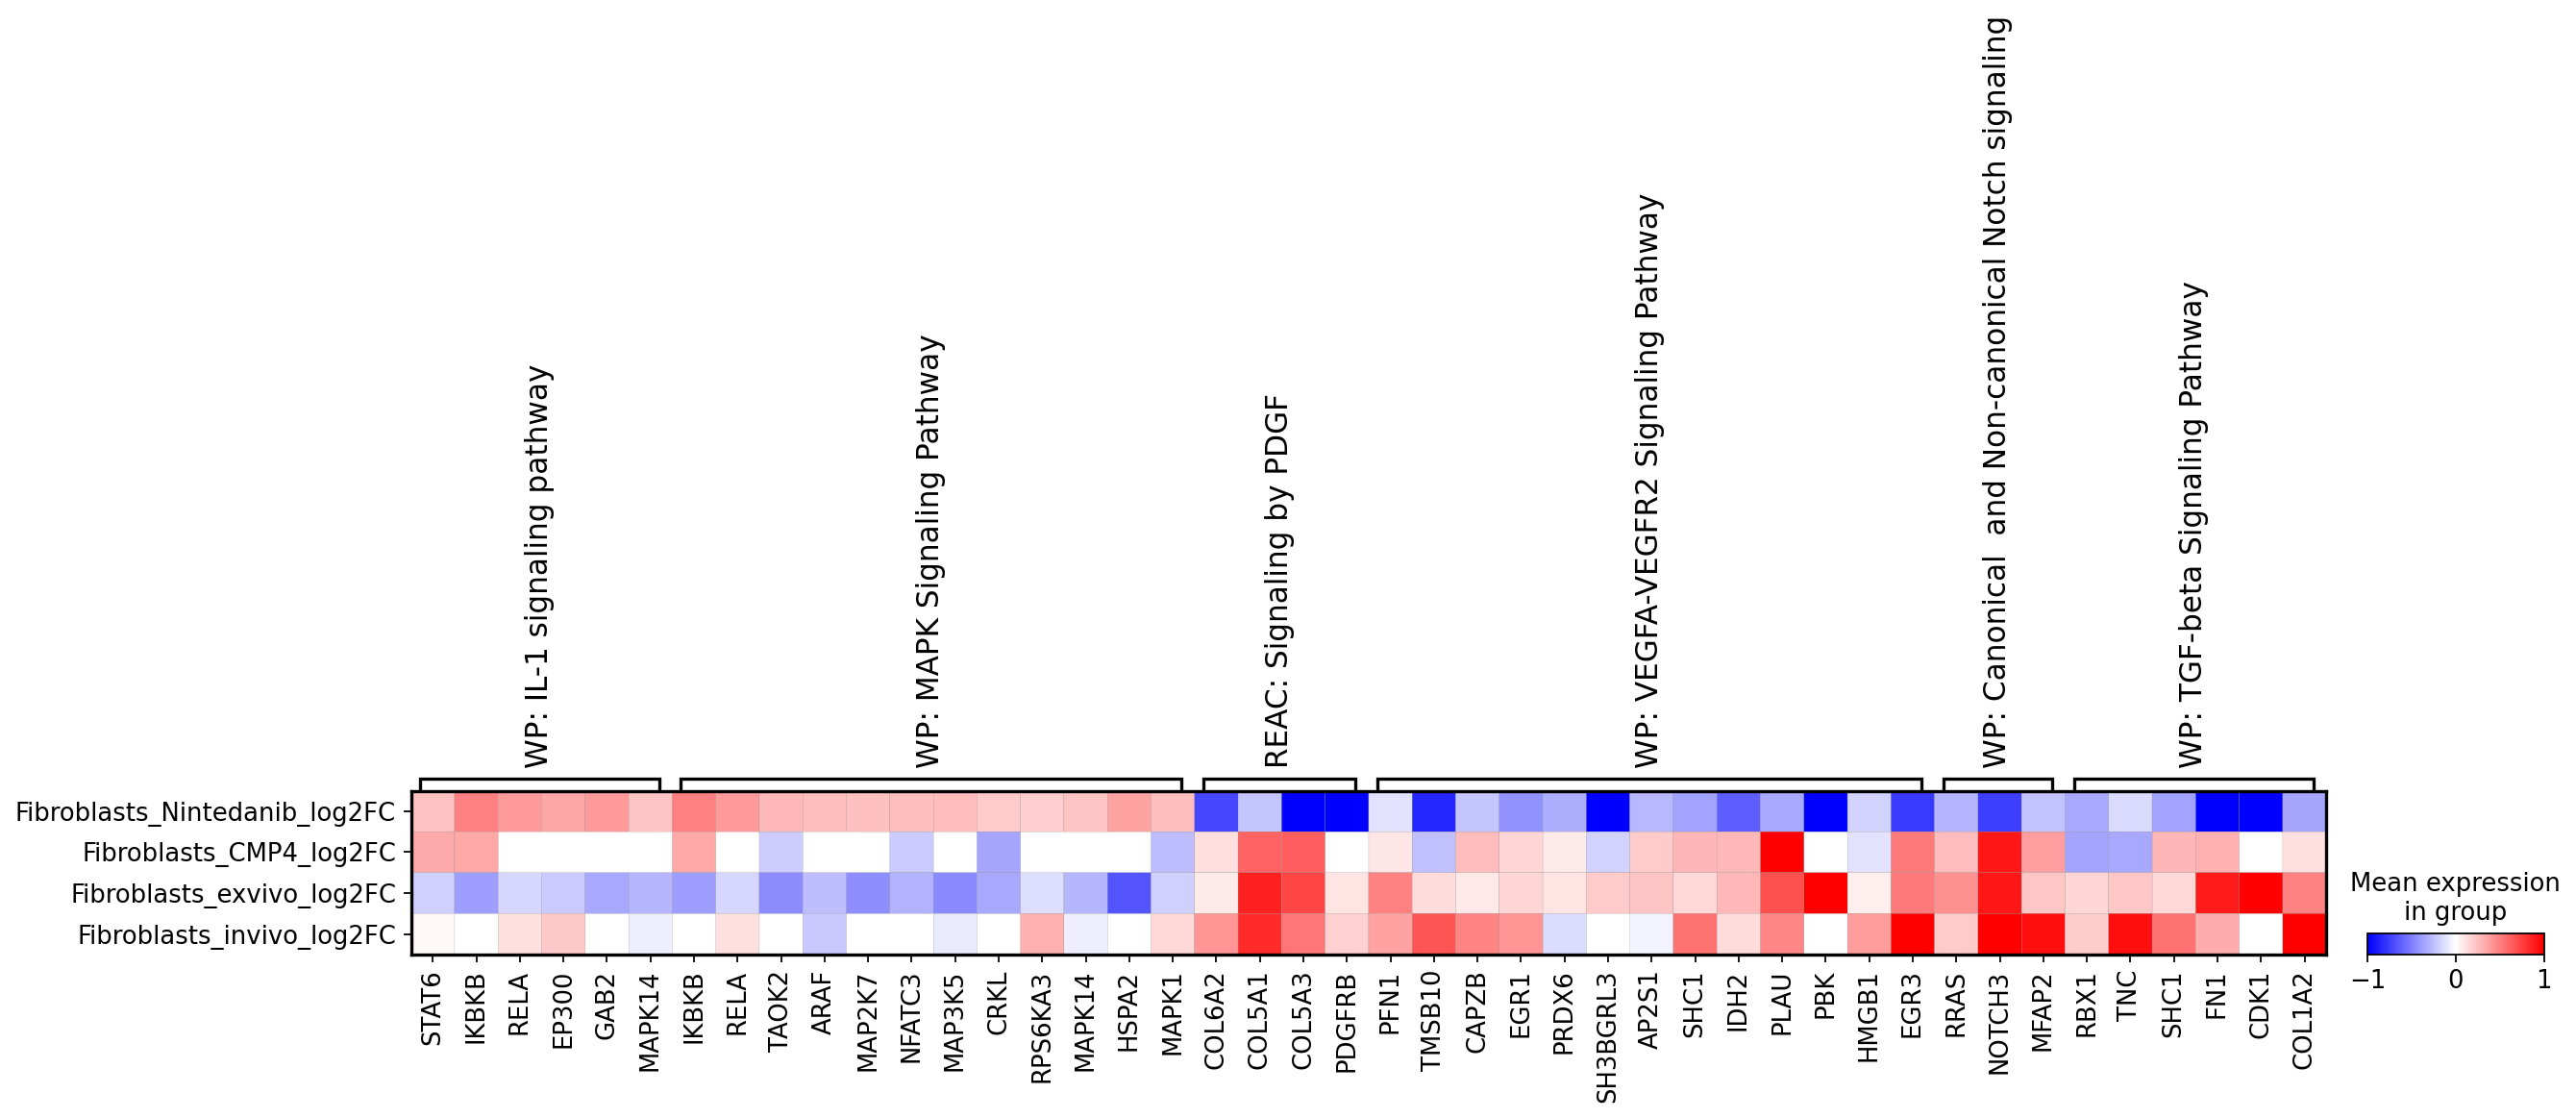

In [12]:
sc.pl.matrixplot(dgetab, gs_dict1, groupby = 'treatment_effect', dendrogram=False,
                 vmin=-1, vmax=1, cmap='bwr', save='hPCLS_Fibroblasts_Nintedanib_effects_DGE.pdf' )

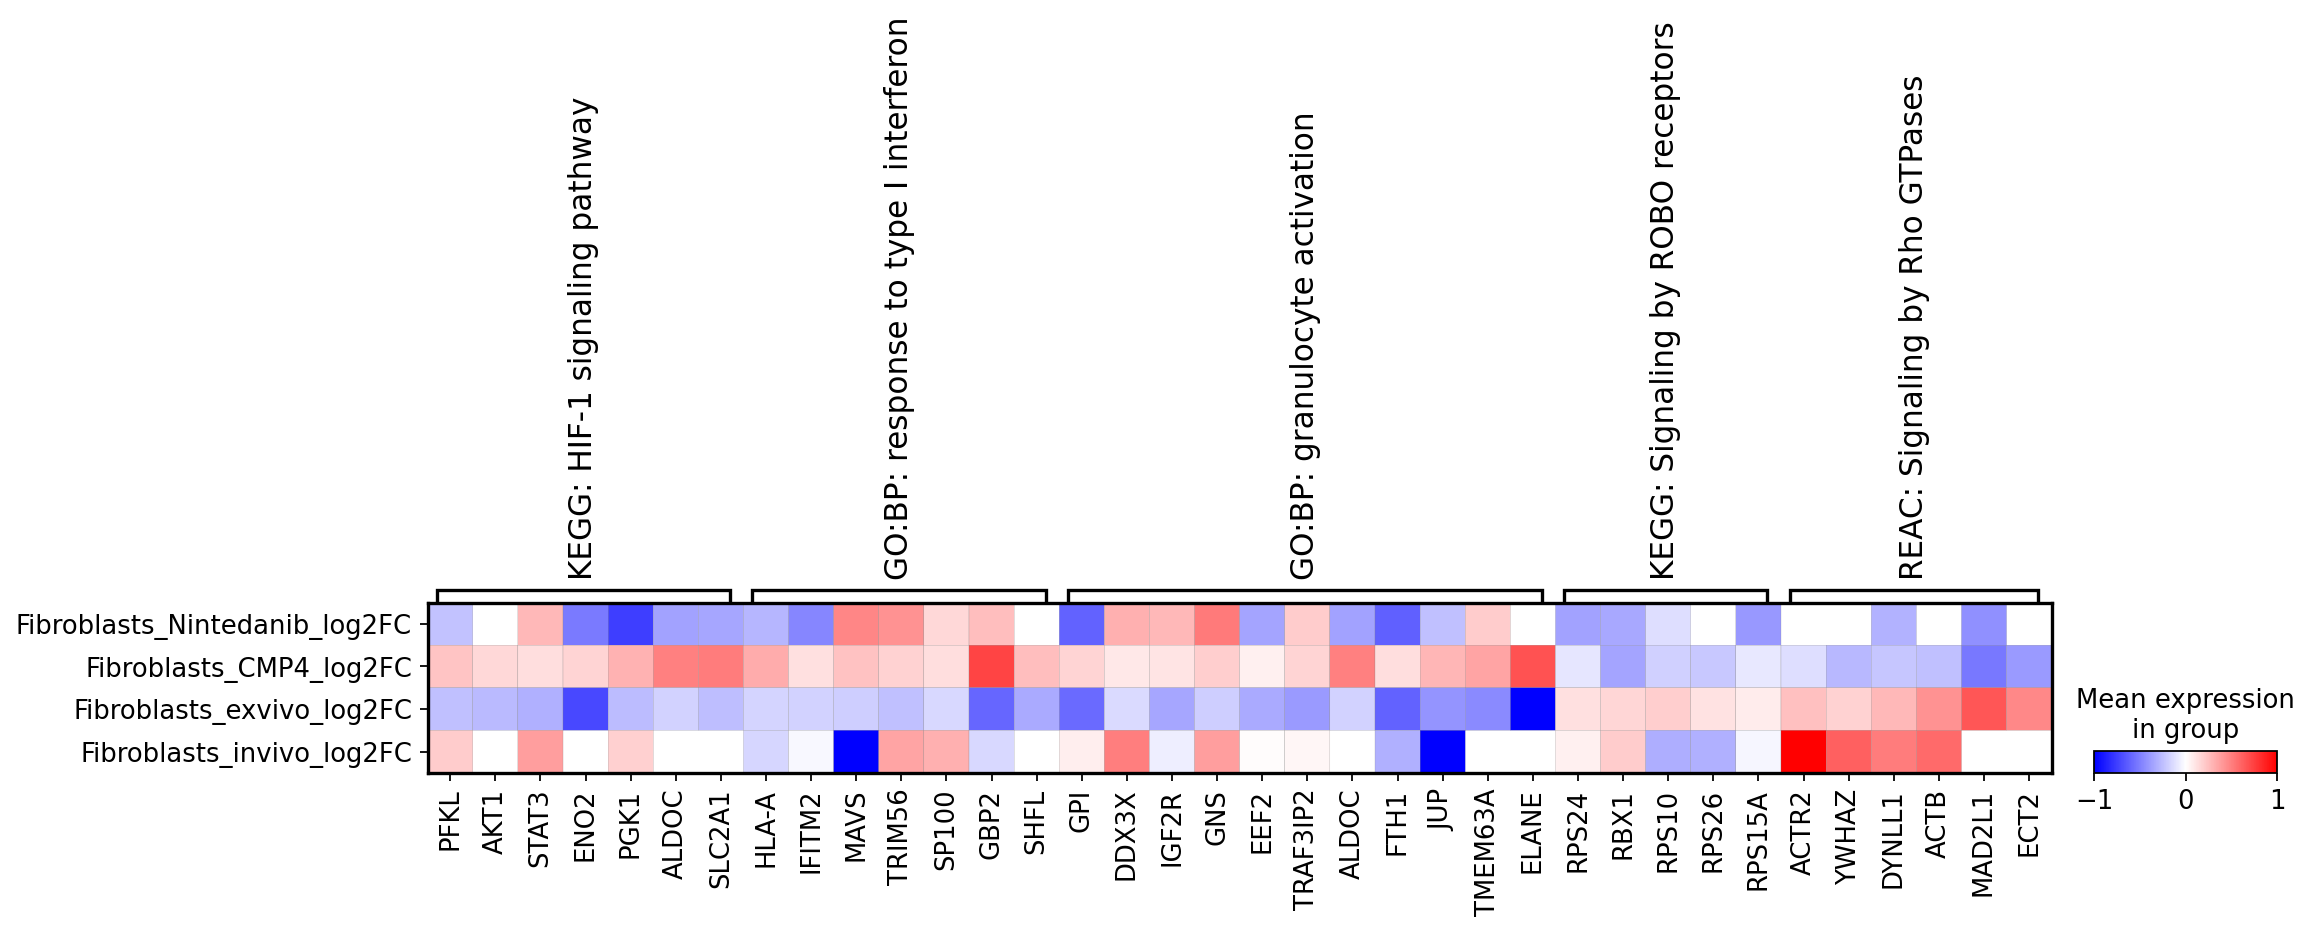

In [13]:
sc.pl.matrixplot(dgetab, gs_dict2, groupby = 'treatment_effect', dendrogram=False,
                 vmin=-1, vmax=1, cmap='bwr', save='hPCLS_Fibroblasts_cmp4_effects_DGE.pdf' )